In [1]:

import os
import time

import ee
import folium
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
from pysheds.grid import Grid
import seaborn as sns


DATA_DIR = os.path.join("..", "..", "data")
gages = pd.read_csv(os.path.join(DATA_DIR, "target_gages.csv"), encoding="utf-8")

In [2]:
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1ARtbsJpCBa2wOLZin1kCdFxa-SgzxDziZBS55gD9w01OHXKF2hYjcgFDm9c



Successfully saved authorization token.


In [3]:
# Import the USGS ground elevation image.
elv = ee.Image("USGS/SRTMGL1_003")

In [4]:
# Example gage for this notebook:
gage = gages.loc[0]
lat, lon = gage["dec_lat_va"], gage["dec_long_va"]
name = gage["site_no"]

In [5]:
# Map the elevation and a region around a streamgage:
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

    
# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Set visualization parameters for ground elevation.
elv_vis_params = {
    'min': 0, 'max': 4000,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']
}

# Create a new map.
my_map = folium.Map(location=[lat, lon], zoom_start=7, width="60%", height="60%")

my_map.add_ee_layer(elv, elv_vis_params, "Elevation")

# Define a region of interest with a buffer zone of 100 km.
poi = ee.Geometry.Point(lon, lat)
roi = poi.buffer(100_000)

# Add the marker where the streamgage is:
gage = gages.loc[0]
lat, lon = gage["dec_lat_va"], gage["dec_long_va"]
name = gage["site_no"]

folium.Marker(location=[lat, lon], 
              radius=10, popup=f"{name} ({lat}, {lon})").add_to(my_map)

folium.GeoJson(roi.getInfo()).add_to(my_map)

my_map

In [ ]:
# Export the geotiff to GDrive for the elevation image in the highlighted polygon:
task = ee.batch.Export.image.toDrive(
    image=elv,
    description=f"Elevation data export for streamgage {name}",
    scale=30,
    region=roi,
    fileNamePrefix=f"{name}_100km_elevation",
    crs="EPSG:4326",
    fileFormat="GeoTIFF"
)

t1 = time.time()
task.start()

while task.active():
    status = task.status()["state"]
    if status in "RUNNING":
        time.sleep(1)
    else:
        t2 = time.time()
        break
        
print(status)
print(f"Time = {t2-t1:,.0f} seconds")

In [6]:
# Get the copy of the tiff file which was saved locally:
tiffile = os.path.join(DATA_DIR, "gage_tiff_files", "11185500_100km_elevation.tif")
grid = Grid.from_raster(tiffile)
dem = grid.read_raster(tiffile)

/Users/tp/virtualenvs/discharge-estimation/lib/python3.9/site-packages/pysheds/io.py:142: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/tp/virtualenvs/discharge-estimation/lib/python3.9/site-packages/pysheds/io.py:142: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


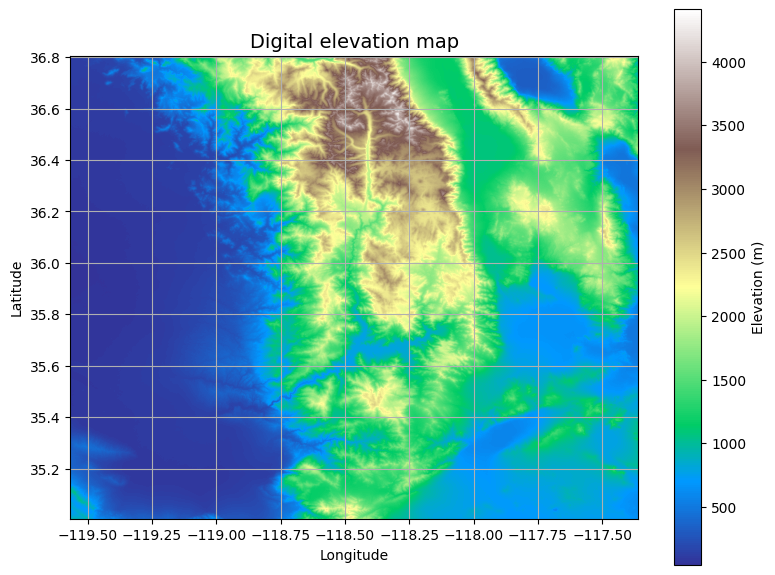

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [8]:
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

In [9]:
# Determine D8 flow directions from DEM
# ----------------------
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    
# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

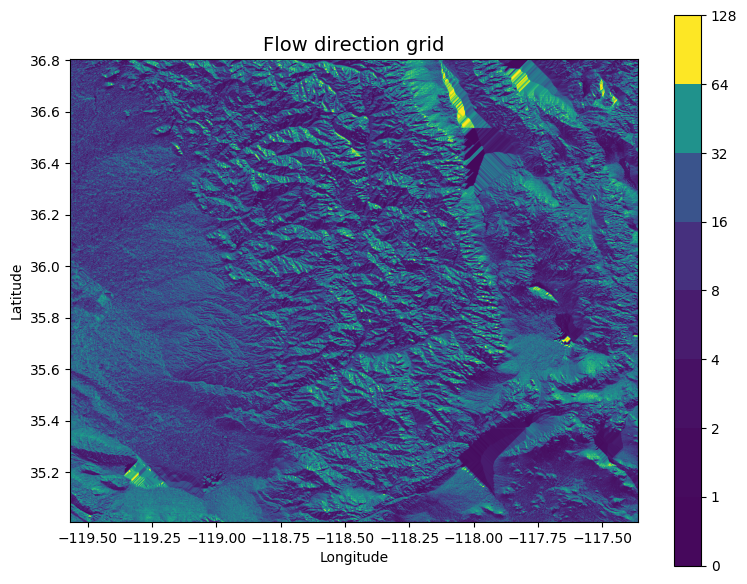

In [10]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

In [11]:
# Calculate flow accumulation
# --------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)

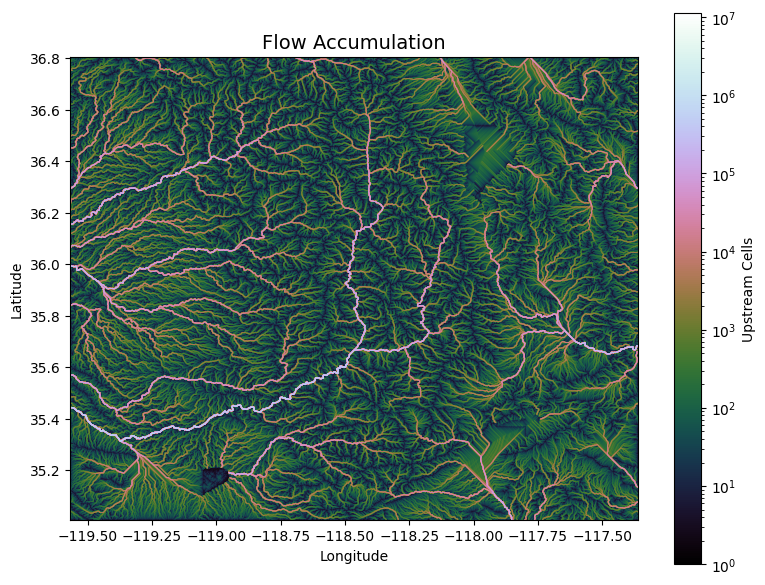

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [13]:
gage = gages.loc[0]
lat, lon = gage["dec_lat_va"], gage["dec_long_va"]
name = gage["site_no"]

# Delineate a catchment
# ---------------------
# Specify pour point
x, y = lon, lat

# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, 
                       xytype='coordinate')

# Crop and plot the catchment
# ---------------------------
# Clip the bounding box to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)

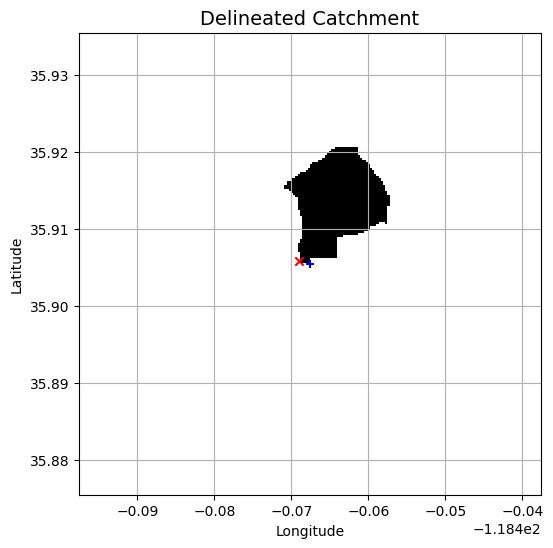

In [14]:
# Plot the catchment:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid.extent,
               zorder=1, cmap='Greys_r')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=14)
lat_long_buffer = 0.03
ax.set_xlim(x-lat_long_buffer, x+lat_long_buffer)
ax.set_ylim(y-lat_long_buffer, y+lat_long_buffer)
ax.scatter([x], [y], color="b", marker="+")
ax.scatter([x_snap], [y_snap], color="r", marker="x")

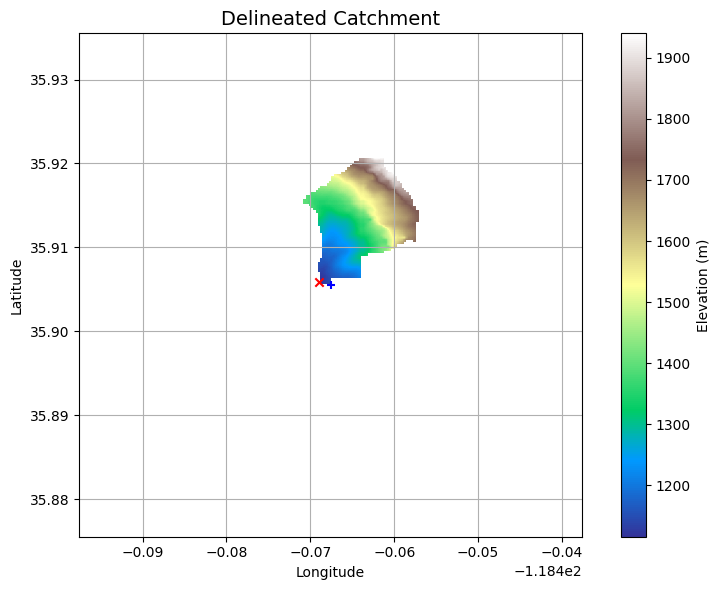

In [15]:
# Plot the catchment in the elevation data:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
clipped_dem = grid.view(dem)
plt.imshow(np.where(clipped_catch, clipped_dem, np.nan), extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')


plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=14)
plt.tight_layout()
lat_long_buffer = 0.03
ax.set_xlim(x-lat_long_buffer, x+lat_long_buffer)
ax.set_ylim(y-lat_long_buffer, y+lat_long_buffer)
ax.scatter([x], [y], color="b", marker="+")
ax.scatter([x_snap], [y_snap], color="r", marker="x")